In [3]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler

In [12]:
demo_city_name = 'ubonratchathani'

In [4]:
region_df = pd.read_csv('dataset/berkeleyearth/region.csv')
region_df.rename({'Unnamed: 0': 'id'}, axis=1, inplace=True)
raw_sensor_df = pd.read_csv('dataset/berkeleyearth/sensor.csv')
raw_sensor_df.rename({'Unnamed: 0': 'id'}, axis=1, inplace=True)
raw_sensor_df['timestamp'] = pd.to_datetime(raw_sensor_df['timestamp'])


In [5]:
raw_sensor_df.head(10)

,id,city,timestamp,pm
0,0,banlamlukka,2016-03-03 08:00:00,63.2
1,1,banlamlukka,2016-03-03 09:00:00,63.2
2,2,banlamlukka,2016-03-03 10:00:00,62.3
3,3,banlamlukka,2016-03-03 11:00:00,62.3
4,4,banlamlukka,2016-03-03 12:00:00,44.1
5,5,banlamlukka,2016-03-03 13:00:00,43.8
6,6,banlamlukka,2016-03-03 14:00:00,33.0
7,7,banlamlukka,2016-03-03 15:00:00,35.6
8,8,banlamlukka,2016-03-03 16:00:00,34.8
9,9,banlamlukka,2016-03-03 17:00:00,49.8


In [6]:
raw_sensor_df['pm'].describe()

count    1.555291e+06
mean     2.398450e+01
std      1.547295e+01
min      6.000000e-01
25%      1.360000e+01
50%      1.950000e+01
75%      2.990000e+01
max      7.879000e+02
Name: pm, dtype: float64

## Initialize Standard Scaler

In [7]:
scaler = StandardScaler()
scaler.fit(raw_sensor_df['pm'].to_numpy().reshape((-1, 1)))

StandardScaler(copy=True, with_mean=True, with_std=True)

# Interpolation

In [8]:
def daily_mean_interpolate(df):
    df = df.drop('id', axis=1).set_index('timestamp').resample('D').mean()
    df['pm'] = df['pm'].interpolate()
    return df.reset_index()
sensor_df = raw_sensor_df.groupby('city').apply(daily_mean_interpolate)

In [9]:
sensor_df.head(10)

timestamp         pm
city                           
bangkok 0 2016-03-03  45.120000
        1 2016-03-04  34.791667
        2 2016-03-05  31.283333
        3 2016-03-06  29.679167
        4 2016-03-07  29.591667
        5 2016-03-08  27.787500
        6 2016-03-09  29.270833
        7 2016-03-10  27.978261
        8 2016-03-11  21.045833
        9 2016-03-12  20.508333

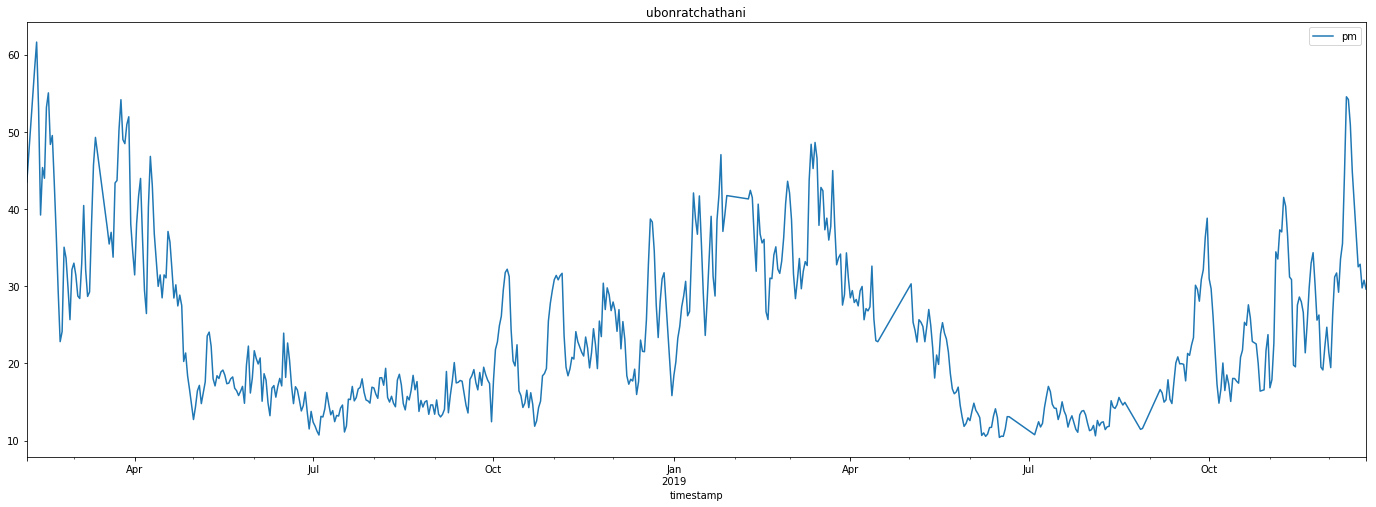

In [13]:
sensor_df.loc[demo_city_name].plot(
    x='timestamp', y='pm', figsize=(24, 8), title=demo_city_name)

# Standardize

In [16]:
pm = sensor_df['pm'].to_numpy().reshape((-1, 1))
sensor_df['pm'] = scaler.transform(pm)

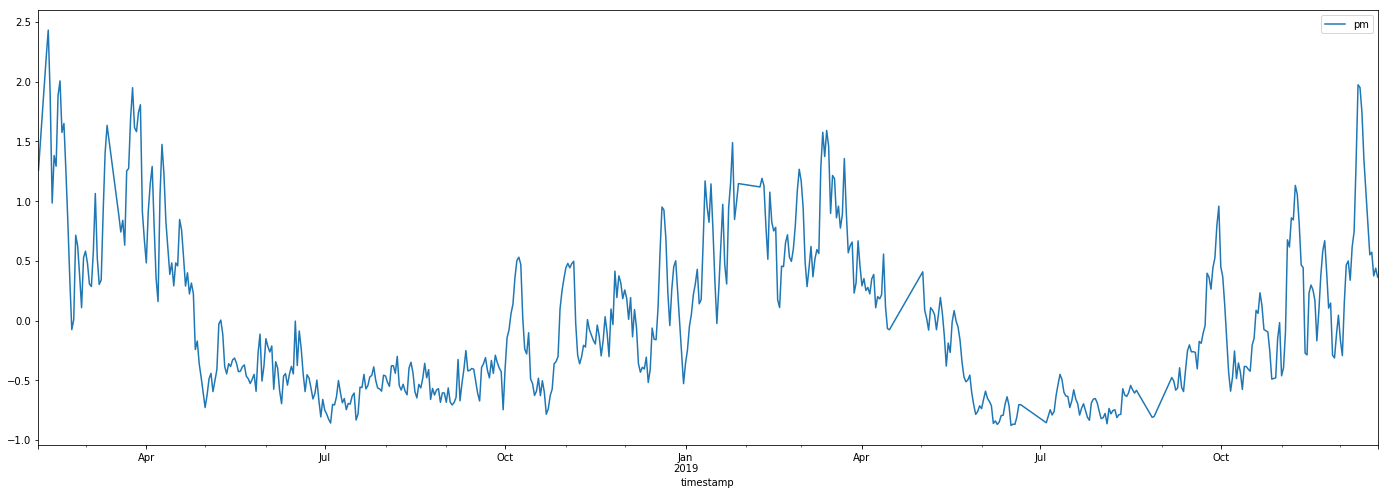

In [18]:
sensor_df.loc[demo_city_name].plot(x='timestamp', y='pm', figsize=(24, 8))

# Train & Test split

In [77]:
split_date = '2019-06-01'
train_sensor = sensor_df[sensor_df['timestamp'] < split_date]
val_sensor = sensor_df[sensor_df['timestamp'] >= split_date]

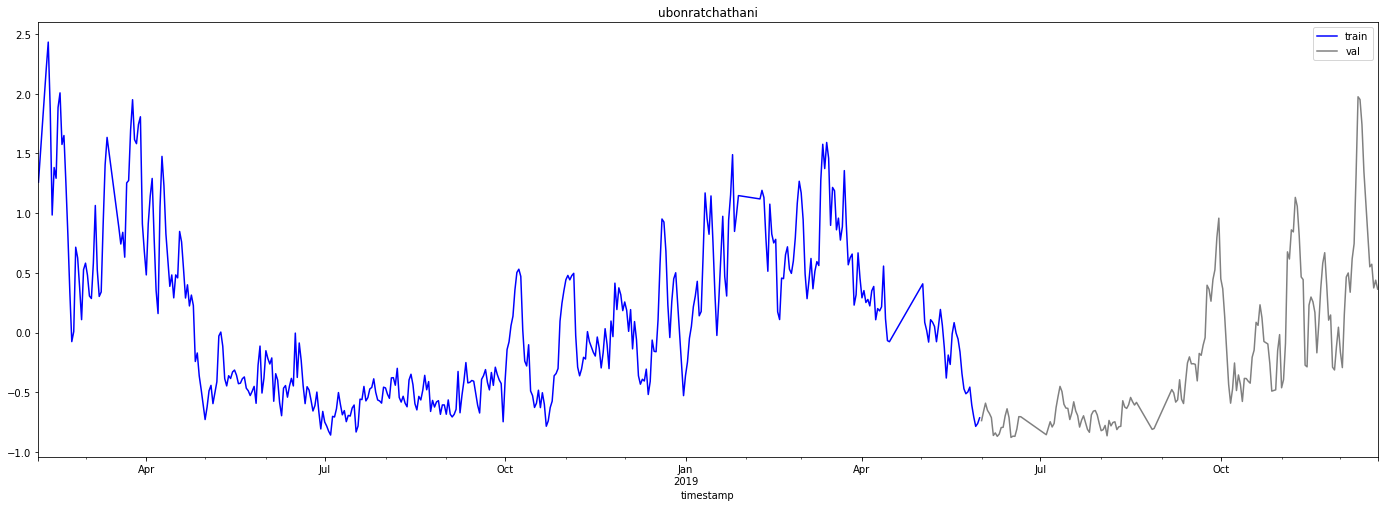

In [78]:
train_city = train_sensor.loc[demo_city_name]
val_city = test_sensor.loc[demo_city_name]

ax = train_city.plot(x='timestamp', y='pm', color='blue',
                     kind='line', label='train')
val_city.plot(x='timestamp', y='pm', color='grey', kind='line',
               title=demo_city_name, label='val', figsize=(24, 8), ax=ax)

# Sliding window

In [148]:
window_size = 7
output_size = 1
stride = 1
batch_size = 32
shuffle = False

city = train_sensor.loc[demo_city_name].copy()


def sliding_window(city_sensor, window_size, output_size, stride):
    city_sensor = city_sensor.sort_values('timestamp')
    pm_series = city_sensor['pm'].to_numpy()

    xs = []
    ys = []
    for i in range(0, len(pm_series)-window_size-output_size+1, stride):
        x = pm_series[i: i+window_size]
        y = pm_series[i+window_size: i+window_size+output_size]

        xs.append(x)
        ys.append(y)
    xs = np.array(xs)
    xs = np.expand_dims(xs, axis=2)
    ys = np.array(ys)

    return xs, ys


def create_all_city(sensor, window_size, output_size, stride):
    data = sensor.groupby('city').apply(
        sliding_window, window_size, output_size, stride).to_numpy()
    
    xs = []
    ys = []
    for (x, y) in data:
        xs.append(x)
        ys.append(y)
    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    return xs, ys


# train_data = train_sensor.groupby('city').apply(
#     sliding_window, window_size, output_size, stride).to_numpy()
# val_data = val_sensor.groupby('city').apply(
#     sliding_window, window_size, output_size, stride).to_numpy()

X, Y = create_all_city(train_sensor, window_size, output_size, stride)
val_X, val_Y = create_all_city(val_sensor, window_size, output_size, stride)

# Model 

In [118]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Input


In [144]:
model = Sequential()
model.add(LSTM(8, return_sequences=True, input_shape=(7, 1)))
model.add(LSTM(4))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 7, 8)              320       
_________________________________________________________________
lstm_9 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [153]:
model.fit(X, Y, validation_data=(val_X, val_Y), shuffle=True, epochs=50)

Train on 64152 samples, validate on 10976 samples
Epoch 1/50
64152/64152 [==============================] - 19s 297us/step - loss: 0.1228 - val_loss: 0.0765
Epoch 2/50
64152/64152 [==============================] - 19s 300us/step - loss: 0.1222 - val_loss: 0.0775
Epoch 3/50
64152/64152 [==============================] - 20s 307us/step - loss: 0.1216 - val_loss: 0.0785
Epoch 4/50
64152/64152 [==============================] - 20s 304us/step - loss: 0.1212 - val_loss: 0.0762
Epoch 5/50
64152/64152 [==============================] - 19s 291us/step - loss: 0.1210 - val_loss: 0.0780
Epoch 6/50
64152/64152 [==============================] - 18s 287us/step - loss: 0.1209 - val_loss: 0.0771
Epoch 7/50
64152/64152 [==============================] - 18s 284us/step - loss: 0.1209 - val_loss: 0.0773
Epoch 8/50
64152/64152 [==============================] - 18s 284us/step - loss: 0.1204 - val_loss: 0.0789
Epoch 9/50
64152/64152 [==============================] - 18s 286us/step - loss: 0.1203 - val_

KeyboardInterrupt: 

# Evaluation

In [216]:
city_name = 'bangkok'
train_city_sensor = train_sensor.loc[city_name]
val_city_sensor = val_sensor.loc[city_name]
def predict_city(city_sensor, scaler=None):
    x, y = sliding_window(city_sensor, window_size, output_size, stride)
    y_pred = model.predict(x, verbose=1)
    
    if scaler is not None:
        y_pred = scaler.inverse_transform(y_pred)
        city_sensor['pm'] = scaler.inverse_transform(city_sensor['pm'])
    
    city_sensor = city_sensor.copy()
    city_sensor['pm_pred'] = np.nan
    city_sensor['pm_pred'][window_size:] = np.squeeze(y_pred)
    
    
    return city_sensor
train_city_sensor = predict_city(train_city_sensor, scaler)
val_city_sensor = predict_city(val_city_sensor, scaler)

1178/1178 [==============================] - 0s 86us/step


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


196/196 [==============================] - 0s 100us/step


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


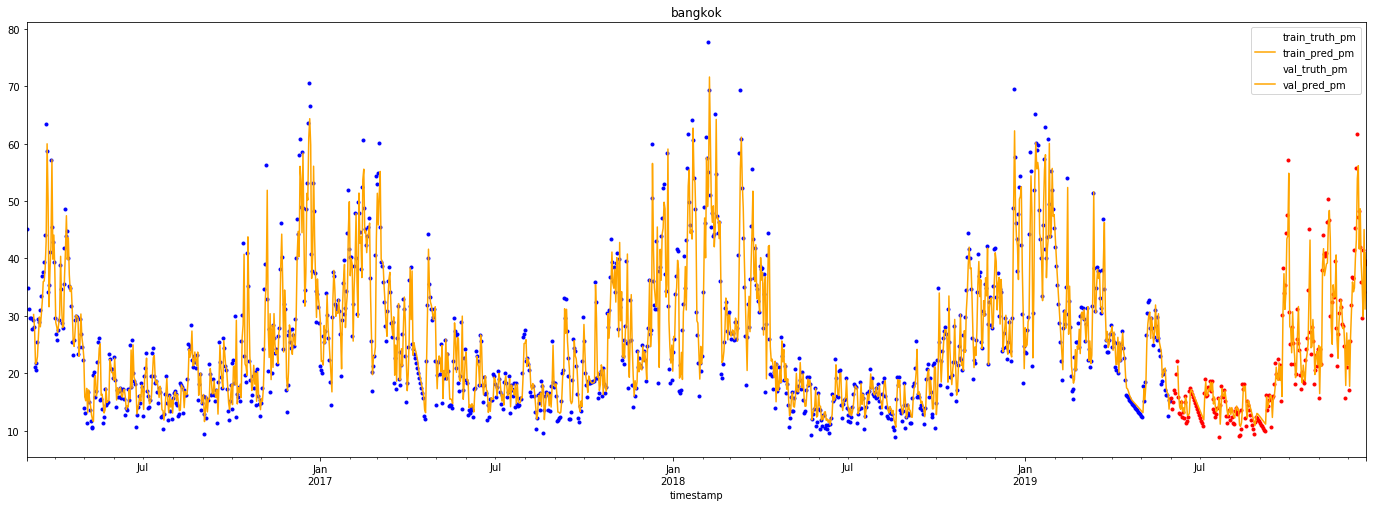

In [218]:
ax = train_city_sensor.plot(x='timestamp', y='pm',
                            figsize=(24, 8), color='blue', style='.', label='train_truth_pm')
ax = train_city_sensor.plot(
    x='timestamp', y='pm_pred', figsize=(24, 8), color='orange', label='train_pred_pm', ax=ax)

ax = val_city_sensor.plot(x='timestamp', y='pm', figsize=(
    24, 8), color='red', style='.', label='val_truth_pm', ax=ax)
val_city_sensor.plot(x='timestamp', y='pm_pred',
                     figsize=(24, 8), color='orange', label='val_pred_pm', ax=ax, title=city_name)

In [196]:
x.shape

(1178, 7, 1)

In [195]:
train_city_sensor.count()

timestamp    1185
pm           1185
dtype: int64